In [92]:
# !pip install snowflake-connector-python


In [2]:
import numpy as np
import math
import pandas as pd
import re
from datetime import date, datetime
import json
from abc import ABCMeta, abstractmethod
import boto3


In [3]:
import snowflake.connector
import os
import sys

In [4]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [5]:
class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

In [6]:
class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [7]:
def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

## Read Data

In [8]:
# wiki_share = run_query('''select REAL_DATE_MONTH, title, platform, imdb_id, PRODUCTION_RELEASE_DATE, COUNTRY,
# CONTENT_TYPE, PRIMARY_GENRE, SECONDARY_GENRE, IN_HOUSE, SCRIPTED, ORIGINAL, PRIMARY_PRODUCTION_COMPANY, PRIMARY_PRODUCTION_PARENT_COMPANY, SUM(PAGE_VIEWS) as page_views
# from max_prod.workspace.cds_competitor_insight_sov_international where country ='United States' 
# GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
#                       ''')

In [9]:
wiki_share = pd.read_csv('wiki_share.csv')
# wiki_share.to_csv('wiki_share.csv')

In [10]:
wiki_share.head()

,Unnamed: 0,real_date_month,title,platform,imdb_id,production_release_date,country,content_type,primary_genre,secondary_genre,in_house,scripted,original,primary_production_company,primary_production_parent_company,page_views
0,0,2021-04-01,"Dancer, Texas Pop. 81",Amazon Prime Video,tt0118925,1998-03-13,United States,Movie,Children & Family,Drama,Licensed,Scripted,Not An Original,hsx films,Sony,547.634973
1,1,2021-10-01,Smother,Peacock,tt11719808,2021-03-07,United States,TVShow,Crime & Thriller,Drama,Licensed,Scripted,Peacock Exclusive,treasure entertainment,BBC,4912.822088
2,2,2020-06-01,'Neath Brooklyn Bridge,Amazon Prime Video,tt0034420,1942-11-20,United States,Movie,Comedy,Drama,Licensed,Scripted,Not An Original,Sam Katzman Productions,Independent / Other,141.715522
3,3,2020-04-01,Old 37,Amazon Prime Video,tt1600429,2015-02-10,United States,Movie,Horror,Action & Adventure,Licensed,Scripted,Not An Original,Big Picture Media Corporation,Lionsgate,2.009938
4,4,2020-11-01,The Reef 2: High Tide,Amazon Prime Video,tt1978567,2012-09-27,United States,Movie,Children & Family,Animation,Licensed,Scripted,Not An Original,WonderWorld Studios,Paramount Global,1176.439496


In [11]:
wiki_share['monthly_platform_view'] = wiki_share.groupby(['real_date_month', 'platform'])['page_views'].transform('sum')

In [12]:
wiki_share['monthly_total_view'] = wiki_share.groupby(['real_date_month'])['page_views'].transform('sum')

In [13]:
wiki_share['real_date_month'] = wiki_share['real_date_month'].astype('datetime64[ns]')

In [14]:
wiki_share_platform = wiki_share.groupby(['real_date_month', 'platform'])[['page_views']].sum().reset_index()

In [15]:
wiki_share_platform['monthly_total_view'] = wiki_share_platform.groupby(['real_date_month'])['page_views'].transform('sum')

In [16]:
wiki_share_platform['monthly_market_share'] = wiki_share_platform['page_views']/wiki_share_platform['monthly_total_view']

In [17]:
wiki_share_platform.head()

,real_date_month,platform,page_views,monthly_total_view,monthly_market_share
0,2020-01-01,AcornTV,1.494255e+06,2.417507e+08,0.006181
1,2020-01-01,Amazon Other,9.489800e+06,2.417507e+08,0.039254
2,2020-01-01,Amazon Prime Video,5.835393e+07,2.417507e+08,0.241381
3,2020-01-01,Apple TV+,8.398505e+05,2.417507e+08,0.003474
4,2020-01-01,Britbox,2.326709e+06,2.417507e+08,0.009624


In [18]:
wiki_share_platform.platform.unique()

array(['AcornTV', 'Amazon Other', 'Amazon Prime Video', 'Apple TV+',
       'Britbox', 'CBS All Access', 'Crunchyroll', 'Disney+',
       'HBO/HBO Max', 'Hotstar', 'Hulu', 'Max Go', 'Netflix',
       'Showtime Anytime', 'Starz Play', 'Epix', 'Shudder',
       'Sundance Now', 'Peacock', 'Mubi', 'CuriosityStream', 'Discovery+',
       'Paramount+', 'Globo Play', 'GuideDoc', 'Kocowa', 'Pantaya',
       'Viki', 'Criterion Channel', 'iQIYI'], dtype=object)

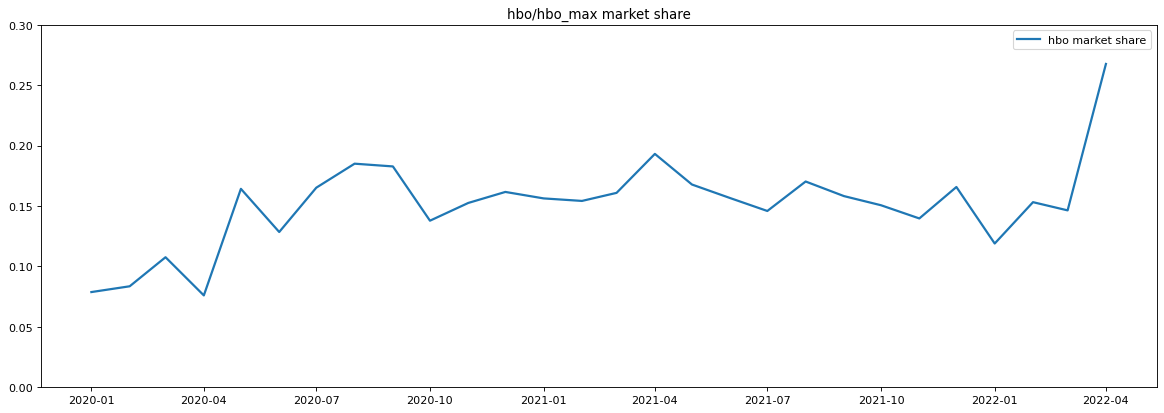

In [19]:
plot_df = wiki_share_platform[wiki_share_platform['platform']=='HBO/HBO Max']
figure(figsize=(18, 6), dpi=80)
plt.plot(plot_df['real_date_month'], plot_df['monthly_market_share'],
                linewidth=2, label = 'hbo market share')
plt.title('hbo/hbo_max market share')
plt.ylim(0, 0.30)
# plt.xlabel('date')
# plt.ylabel('total actives')
plt.legend()
plt.show()

In [20]:
wiki_share['title_market_share'] = wiki_share['page_views']/wiki_share['monthly_total_view']

In [21]:
wiki_share["rank"] = wiki_share.groupby("real_date_month")["title_market_share"].rank(method='first', ascending=False)

In [22]:
wiki_share_bbo= wiki_share[wiki_share['platform']=='HBO/HBO Max']

In [23]:
wiki_share_bbo[wiki_share_bbo['rank']<10].sort_values(by = ['real_date_month'])

,Unnamed: 0,real_date_month,title,platform,imdb_id,production_release_date,country,content_type,primary_genre,secondary_genre,in_house,scripted,original,primary_production_company,primary_production_parent_company,page_views,monthly_platform_view,monthly_total_view,title_market_share,rank
646265,646265,2020-01-01,Once Upon a Time... In Hollywood,HBO/HBO Max,tt7131622,2019-05-21,United States,Movie,Comedy,Drama,Licensed,Scripted,Not An Original,Columbia Pictures,Lantern Entertainment,1.265775e+06,1.904360e+07,2.417507e+08,0.005236,7.0
354835,354835,2020-02-01,The Invisible Man,HBO/HBO Max,tt1051906,2020-02-24,United States,Movie,Horror,Suspense,Licensed,Scripted,Not An Original,Universal TV,Disney,9.707635e+05,1.841989e+07,2.204470e+08,0.004404,7.0
304019,304019,2020-02-01,Once Upon a Time... In Hollywood,HBO/HBO Max,tt7131622,2019-05-21,United States,Movie,Comedy,Drama,Licensed,Scripted,Not An Original,Columbia Pictures,Lantern Entertainment,1.026546e+06,1.841989e+07,2.204470e+08,0.004657,5.0
558807,558807,2020-03-01,Once Upon a Time... In Hollywood,HBO/HBO Max,tt7131622,2019-05-21,United States,Movie,Comedy,Drama,Licensed,Scripted,Not An Original,Columbia Pictures,Lantern Entertainment,1.314981e+06,3.075311e+07,2.857962e+08,0.004601,4.0
443730,443730,2020-03-01,The Invisible Man,HBO/HBO Max,tt1051906,2020-02-24,United States,Movie,Horror,Suspense,Licensed,Scripted,Not An Original,Universal TV,Disney,2.012823e+06,3.075311e+07,2.857962e+08,0.007043,2.0
648596,648596,2020-08-01,Joker,HBO/HBO Max,tt7286456,2019-08-31,United States,Movie,Crime & Thriller,Drama,Licensed,Scripted,Not An Original,DC Comics,WarnerMedia,7.260265e+05,5.890200e+07,3.183054e+08,0.002281,9.0
65271,65271,2020-08-01,Lovecraft Country,HBO/HBO Max,tt6905686,2020-08-16,United States,TVShow,Sci-Fi & Fantasy,Drama,Licensed,Scripted,Not An Original,Warner Bros,WarnerMedia,1.012740e+06,5.890200e+07,3.183054e+08,0.003182,4.0
436160,436160,2020-09-01,Raised by Wolves,HBO/HBO Max,tt9170108,2020-09-03,United States,TVShow,Sci-Fi & Fantasy,Drama,Licensed,Scripted,HBO Max Original,Scott Free Productions,WarnerMedia,1.181093e+06,5.420760e+07,2.965800e+08,0.003982,7.0
207819,207819,2020-11-01,His Dark Materials,HBO/HBO Max,tt5607976,2019-11-03,United States,TVShow,Sci-Fi & Fantasy,Action & Adventure,Licensed,Scripted,HBO Original,New Line Cinema,WarnerMedia,7.805081e+05,4.472145e+07,2.931615e+08,0.002662,7.0
209942,209942,2020-12-01,Wonder Woman 1984,HBO/HBO Max,tt7126948,2020-12-16,United States,Movie,Sci-Fi & Fantasy,Action & Adventure,Licensed,Scripted,Not An Original,DC Comics,WarnerMedia,2.477179e+06,5.130025e+07,3.173326e+08,0.007806,3.0


In [24]:
top_10 = wiki_share.sort_values(by = ['real_date_month', 'title_market_share'], ascending = False).groupby(['real_date_month']).head(10)[['real_date_month', 'title', 'title_market_share']]

# Amazon Content 

In [11]:
wiki_share.head()

,Unnamed: 0,real_date_month,title,platform,imdb_id,production_release_date,country,content_type,primary_genre,secondary_genre,in_house,scripted,original,primary_production_company,primary_production_parent_company,page_views
0,0,2021-04-01,"Dancer, Texas Pop. 81",Amazon Prime Video,tt0118925,1998-03-13,United States,Movie,Children & Family,Drama,Licensed,Scripted,Not An Original,hsx films,Sony,547.634973
1,1,2021-10-01,Smother,Peacock,tt11719808,2021-03-07,United States,TVShow,Crime & Thriller,Drama,Licensed,Scripted,Peacock Exclusive,treasure entertainment,BBC,4912.822088
2,2,2020-06-01,'Neath Brooklyn Bridge,Amazon Prime Video,tt0034420,1942-11-20,United States,Movie,Comedy,Drama,Licensed,Scripted,Not An Original,Sam Katzman Productions,Independent / Other,141.715522
3,3,2020-04-01,Old 37,Amazon Prime Video,tt1600429,2015-02-10,United States,Movie,Horror,Action & Adventure,Licensed,Scripted,Not An Original,Big Picture Media Corporation,Lionsgate,2.009938
4,4,2020-11-01,The Reef 2: High Tide,Amazon Prime Video,tt1978567,2012-09-27,United States,Movie,Children & Family,Animation,Licensed,Scripted,Not An Original,WonderWorld Studios,Paramount Global,1176.439496


In [31]:
amazon_content = wiki_share[wiki_share['platform'] == 'Amazon Prime Video']
amazon_07 = amazon_content[amazon_content['real_date_month'] == '2021-07-01']
amazon_04 = amazon_content[amazon_content['real_date_month'] == '2021-04-01']

In [32]:
missing_content = amazon_04[~amazon_04['imdb_id'].isin(amazon_07.imdb_id)]
missing_content.drop(['Unnamed: 0'], axis = 1, inplace = True)
missing_content = missing_content.groupby(['title', 'imdb_id', 'content_type', 'primary_genre', 'in_house', 'scripted', 'original']).sum().reset_index()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
missing_content.head()

,title,imdb_id,content_type,primary_genre,in_house,scripted,original,page_views
0,"$50, 000 Reward",tt0014639,Movie,Action & Adventure,Licensed,Scripted,Not An Original,29.798759
1,(Untitled),tt1132193,Movie,Romance,Licensed,Scripted,Not An Original,431.691880
2,.45,tt0259822,Movie,Crime & Thriller,Licensed,Scripted,Not An Original,1112.071750
3,"1,000 Convicts and a Woman",tt0066731,Movie,Crime & Thriller,Licensed,Scripted,Not An Original,121.843815
4,10 Endrathukulla,tt5128266,Movie,Crime & Thriller,Licensed,Scripted,Not An Original,5177.702880


In [35]:
missing_content.sort_values(by = 'page_views', ascending = False).head(20)

,title,imdb_id,content_type,primary_genre,in_house,scripted,original,page_views
3993,The Avengers,tt0848228,Movie,Sci-Fi & Fantasy,Licensed,Scripted,Not An Original,355345.350890
821,Captain America: The First Avenger,tt0458339,Movie,Sci-Fi & Fantasy,Licensed,Scripted,Not An Original,312677.878235
457,Back to the Future,tt0088763,Movie,Sci-Fi & Fantasy,Licensed,Scripted,Not An Original,222539.111308
4086,The Challenge,tt0176095,TVShow,Entertainment,Licensed,Unscripted,Not An Original,203770.761200
4627,The Sopranos,tt0141842,Movie,Documentary,Licensed,Unscripted,Not An Original,193470.103357
966,Coming to America,tt0094898,Movie,Romance,Licensed,Scripted,Not An Original,177884.138308
4537,The Prestige,tt0482571,Movie,Sci-Fi & Fantasy,Licensed,Scripted,Not An Original,173582.824341
4508,The Passion of the Christ,tt0335345,Movie,Drama,Licensed,Scripted,Not An Original,167424.016563
116,A Star Is Born,tt1517451,Movie,Romance,Licensed,Scripted,Not An Original,163023.111155
1790,Heartland,tt1094229,TVShow,Drama,Licensed,Scripted,Not An Original,162898.175113


# Evergreen Content

In [30]:
wiki_share.head()

,Unnamed: 0,real_date_month,title,platform,imdb_id,production_release_date,country,content_type,primary_genre,secondary_genre,in_house,scripted,original,primary_production_company,primary_production_parent_company,page_views,monthly_platform_view,monthly_total_view,title_market_share,rank
0,0,2021-04-01,"Dancer, Texas Pop. 81",Amazon Prime Video,tt0118925,1998-03-13,United States,Movie,Children & Family,Drama,Licensed,Scripted,Not An Original,hsx films,Sony,547.634973,5.427080e+07,3.487212e+08,1.570409e-06,17948.0
1,1,2021-10-01,Smother,Peacock,tt11719808,2021-03-07,United States,TVShow,Crime & Thriller,Drama,Licensed,Scripted,Peacock Exclusive,treasure entertainment,BBC,4912.822088,1.729931e+07,3.335523e+08,1.472879e-05,9114.0
2,2,2020-06-01,'Neath Brooklyn Bridge,Amazon Prime Video,tt0034420,1942-11-20,United States,Movie,Comedy,Drama,Licensed,Scripted,Not An Original,Sam Katzman Productions,Independent / Other,141.715522,1.297361e+08,4.024089e+08,3.521679e-07,20764.0
3,3,2020-04-01,Old 37,Amazon Prime Video,tt1600429,2015-02-10,United States,Movie,Horror,Action & Adventure,Licensed,Scripted,Not An Original,Big Picture Media Corporation,Lionsgate,2.009938,8.450066e+07,3.439085e+08,5.844398e-09,21817.0
4,4,2020-11-01,The Reef 2: High Tide,Amazon Prime Video,tt1978567,2012-09-27,United States,Movie,Children & Family,Animation,Licensed,Scripted,Not An Original,WonderWorld Studios,Paramount Global,1176.439496,6.040067e+07,2.931615e+08,4.012939e-06,14803.0


In [60]:
wiki_share_pre = wiki_share.copy()

In [63]:
wiki_pre = wiki_share[['imdb_id', 'real_date_month', 'platform']]

In [64]:
wiki_pre['real_date_month'] =  (pd.to_datetime(wiki_pre['real_date_month']) + pd.DateOffset(months=1)).dt.strftime('%Y-%m-%d')
wiki_pre.rename(columns = {'platform':'platform_previous'}, inplace = True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [65]:
wiki_pre.head()

,imdb_id,real_date_month,platform_previous
0,tt0118925,2021-05-01,Amazon Prime Video
1,tt11719808,2021-11-01,Peacock
2,tt0034420,2020-07-01,Amazon Prime Video
3,tt1600429,2020-05-01,Amazon Prime Video
4,tt1978567,2020-12-01,Amazon Prime Video


In [66]:
wiki_share_pre = wiki_share_pre.merge(wiki_pre, on = ['imdb_id', 'real_date_month'])

In [68]:
wiki_share_pre.head()

,Unnamed: 0,real_date_month,title,platform,imdb_id,production_release_date,country,content_type,primary_genre,secondary_genre,in_house,scripted,original,primary_production_company,primary_production_parent_company,page_views,platform_previous
0,0,2021-04-01,"Dancer, Texas Pop. 81",Amazon Prime Video,tt0118925,1998-03-13,United States,Movie,Children & Family,Drama,Licensed,Scripted,Not An Original,hsx films,Sony,547.634973,Amazon Prime Video
1,1,2021-10-01,Smother,Peacock,tt11719808,2021-03-07,United States,TVShow,Crime & Thriller,Drama,Licensed,Scripted,Peacock Exclusive,treasure entertainment,BBC,4912.822088,Peacock
2,3,2020-04-01,Old 37,Amazon Prime Video,tt1600429,2015-02-10,United States,Movie,Horror,Action & Adventure,Licensed,Scripted,Not An Original,Big Picture Media Corporation,Lionsgate,2.009938,Amazon Prime Video
3,4,2020-11-01,The Reef 2: High Tide,Amazon Prime Video,tt1978567,2012-09-27,United States,Movie,Children & Family,Animation,Licensed,Scripted,Not An Original,WonderWorld Studios,Paramount Global,1176.439496,Amazon Prime Video
4,5,2021-01-01,Smokey Bites the Dust,Amazon Prime Video,tt0083097,1981-06-05,United States,Movie,Romance,Comedy,Licensed,Scripted,Not An Original,New World Pictures,Independent / Other,427.596757,Amazon Prime Video


In [69]:
wiki_share_pre[wiki_share_pre['platform'] != wiki_share_pre['platform_previous']].sort_values(by = ['page_views'], ascending = False).head(20)

,Unnamed: 0,real_date_month,title,platform,imdb_id,production_release_date,country,content_type,primary_genre,secondary_genre,in_house,scripted,original,primary_production_company,primary_production_parent_company,page_views,platform_previous
289323,491535,2021-07-01,Loki,Disney+,tt9140554,2021-06-09,United States,TVShow,Sci-Fi & Fantasy,Action & Adventure,Licensed,Scripted,Disney+ Original,Marvel Studios,Disney,4.911063e+06,Hotstar
285016,330885,2020-09-01,Cobra Kai,Netflix,tt7221388,2018-05-06,United States,TVShow,Action & Adventure,Drama,Licensed,Scripted,Netflix Original,Constantin Film,Sony,3.382448e+06,Amazon Prime Video
170239,103814,2021-01-01,The Expanse,Amazon Prime Video,tt3230854,2015-11-23,United States,TVShow,Sci-Fi & Fantasy,Drama,Licensed,Scripted,Amazon Original,Alcon Entertainment,NBCUniversal,3.375865e+06,Amazon Other
3562,434284,2020-06-01,The Annoying Orange,Amazon Other,tt1715368,2009-10-08,United States,Movie,Comedy,Animation,Licensed,Scripted,Not An Original,No Company Assigned,Independent / Other,3.050457e+06,Amazon Prime Video
489548,355334,2021-02-01,The Expanse,Amazon Prime Video,tt3230854,2015-11-23,United States,TVShow,Sci-Fi & Fantasy,Drama,Licensed,Scripted,Amazon Original,Alcon Entertainment,NBCUniversal,2.949413e+06,Amazon Other
137663,82240,2020-12-01,The Expanse,Amazon Prime Video,tt3230854,2015-11-23,United States,TVShow,Sci-Fi & Fantasy,Drama,Licensed,Scripted,Amazon Original,Alcon Entertainment,NBCUniversal,2.821944e+06,Amazon Other
50892,29108,2021-08-01,Downton Abbey,Amazon Prime Video,tt1606375,2011-09-18,United States,TVShow,Drama,Historical,Licensed,Scripted,Not An Original,Carnival Film & Television,NBCUniversal,2.566659e+06,Peacock
50890,29108,2021-08-01,Downton Abbey,Amazon Prime Video,tt1606375,2011-09-18,United States,TVShow,Drama,Historical,Licensed,Scripted,Not An Original,Carnival Film & Television,NBCUniversal,2.566659e+06,Netflix
50889,29108,2021-08-01,Downton Abbey,Amazon Prime Video,tt1606375,2011-09-18,United States,TVShow,Drama,Historical,Licensed,Scripted,Not An Original,Carnival Film & Television,NBCUniversal,2.566659e+06,Britbox
289322,187845,2021-07-01,Loki,Hotstar,tt9140554,2021-06-09,United States,Movie,Romance,Action & Adventure,Licensed,Scripted,Not An Original,No Company Assigned,Independent / Other,2.455531e+06,Disney+


In [24]:
wiki_share[wiki_share['imdb_id'] == 'tt0121955'].sort_values(by = ['real_date_month'])

,Unnamed: 0,real_date_month,title,platform,imdb_id,production_release_date,country,content_type,primary_genre,secondary_genre,in_house,scripted,original,primary_production_company,primary_production_parent_company,page_views,monthly_platform_view,monthly_total_view,title_market_share,rank
332072,332072,2020-01-01,South Park,Hulu,tt0121955,2005-03-08,United States,TVShow,Comedy,Animation,Licensed,Scripted,Not An Original,Comedy Central,Paramount Global,195204.406184,2.986936e+07,2.417507e+08,0.000807,130.0
460286,460286,2020-02-01,South Park,Hulu,tt0121955,2005-03-08,United States,TVShow,Comedy,Animation,Licensed,Scripted,Not An Original,Comedy Central,Paramount Global,148223.506226,2.655237e+07,2.204470e+08,0.000672,166.0
73286,73286,2020-03-01,South Park,Hulu,tt0121955,2005-03-08,United States,TVShow,Comedy,Animation,Licensed,Scripted,Not An Original,Comedy Central,Paramount Global,163271.541248,3.102027e+07,2.857962e+08,0.000571,199.0
191840,191840,2020-04-01,South Park,Hulu,tt0121955,2005-03-08,United States,TVShow,Comedy,Animation,Licensed,Scripted,Not An Original,Comedy Central,Paramount Global,188353.749860,4.094659e+07,3.439085e+08,0.000548,224.0
220734,220734,2020-05-01,South Park,Hulu,tt0121955,2005-03-08,United States,TVShow,Comedy,Animation,Licensed,Scripted,Not An Original,Comedy Central,Paramount Global,205625.997852,4.125276e+07,3.447483e+08,0.000596,203.0
26790,26790,2020-06-01,South Park,HBO/HBO Max,tt0121955,2005-03-08,United States,TVShow,Comedy,Animation,Licensed,Scripted,Not An Original,Comedy Central,Paramount Global,97314.537128,5.170676e+07,4.024089e+08,0.000242,745.0
511572,511572,2020-06-01,South Park,Hulu,tt0121955,2005-03-08,United States,TVShow,Comedy,Animation,Licensed,Scripted,Not An Original,Comedy Central,Paramount Global,194629.074256,3.450871e+07,4.024089e+08,0.000484,286.0
569294,569294,2020-07-01,South Park,HBO/HBO Max,tt0121955,2005-03-08,United States,TVShow,Comedy,Animation,Licensed,Scripted,Not An Original,Comedy Central,Paramount Global,99652.885952,5.181929e+07,3.137258e+08,0.000318,523.0
441289,441289,2020-08-01,South Park,HBO/HBO Max,tt0121955,2005-03-08,United States,TVShow,Comedy,Animation,Licensed,Scripted,Not An Original,Comedy Central,Paramount Global,106820.122345,5.890200e+07,3.183054e+08,0.000336,495.0
414427,414427,2020-09-01,South Park,HBO/HBO Max,tt0121955,2005-03-08,United States,TVShow,Comedy,Animation,Licensed,Scripted,Not An Original,Comedy Central,Paramount Global,147051.490314,5.420760e+07,2.965800e+08,0.000496,238.0


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


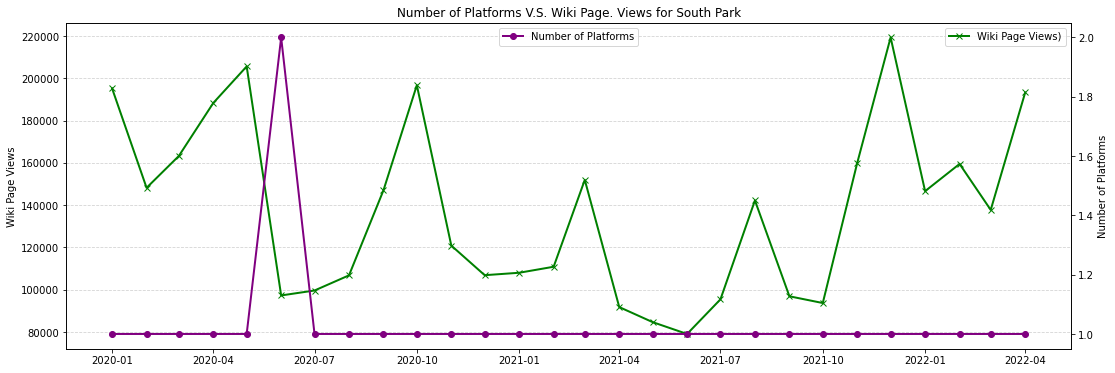

In [26]:
plot_df = wiki_share[wiki_share['imdb_id']=='tt0121955']
plot_df['real_date_month'] = pd.to_datetime(plot_df['real_date_month'])
plot_df_1 = plot_df.groupby(['title', 'imdb_id', 'real_date_month']).first().reset_index()
plot_df_2 = plot_df.groupby(['title', 'imdb_id', 'real_date_month']).count().reset_index()


fig, ax = plt.subplots(figsize=(18,6))
ax2 = ax.twinx()
ax.set_title('Number of Platforms V.S. Wiki Page. Views for South Park')


ax.plot(plot_df_1['real_date_month'], plot_df_1['page_views'],linewidth=2, label = 'Wiki Page Views', color='green', marker='x')
ax2.plot(plot_df_2['real_date_month'], plot_df_2['platform'],linewidth=2, label = '# of Platforms', color='purple', marker='o')
ax.set_ylabel('Wiki Page Views')
ax2.set_ylabel('Number of Platforms')
ax.yaxis.grid(color='lightgray', linestyle='dashed')
ax.legend(['Wiki Page Views)'])
ax2.legend(['Number of Platforms'], loc='upper center')


plt.show()

# v.s. on Chanel

In [126]:
viewing_accounts = run_query('''
with data as 
    (select title, dateadd(day, days_on_hbo_max-1, first_release_date) as request_date, DAILY_VIEWING_SUBS
    from max_prod.content_analytics.new_title_release_days_on_platform)
select date_trunc('MONTH', request_date)as date_month, SUM(DAILY_VIEWING_SUBS) AS viewing_accounts
from data
group by 1
''')

In [129]:
viewing_accounts=viewing_accounts[viewing_accounts['date_month']<= pd.to_datetime('2022-04-01')]
viewing_accounts.sort_values(by = ['date_month'], inplace = True)

In [110]:
first_views = run_query('''
SELECT date_trunc('MONTH', REQUEST_DATE)as date_month, SUM(FIRST_VIEWS) AS first_views
FROM MAX_PROD.CONTENT_ANALYTICS.PSI_DAILY_RW_MEAN_FORECAST
GROUP BY 1
''')

In [122]:
first_views=first_views[first_views['date_month']<= pd.to_datetime('2022-04-01')]
first_views.sort_values(by = ['date_month'], inplace = True)

In [113]:
first_views.sort_values(by = ['date_month']).head()

,date_month,first_views
51,2020-05-01,220299
15,2020-06-01,348365
31,2020-07-01,565020
4,2020-08-01,730854
1,2020-09-01,705545


In [130]:
viewing_accounts.head()

,date_month,viewing_accounts
0,2020-05-01,18811291
21,2020-06-01,118259351
3,2020-07-01,155870969
12,2020-08-01,195600531
4,2020-09-01,240806084


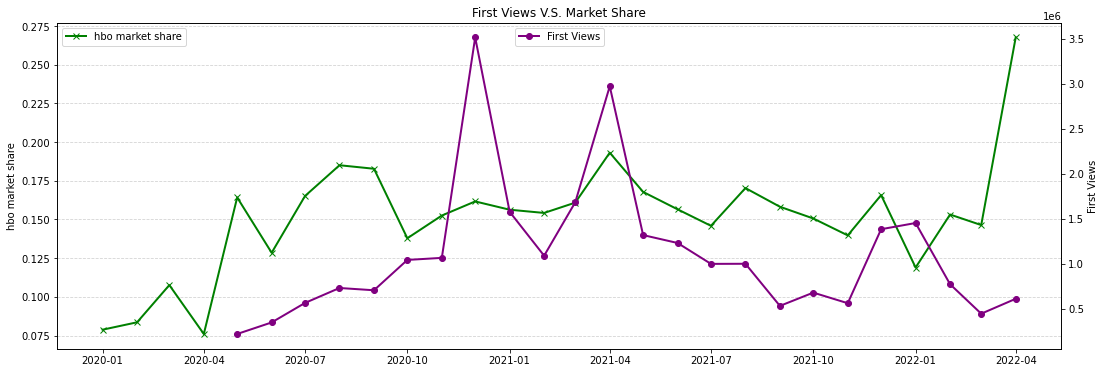

In [146]:
plot_df_1 = wiki_share_platform[wiki_share_platform['platform']=='HBO/HBO Max']
# plot_df['real_date_month'] = pd.to_datetime(plot_df['real_date_month'])
plot_df_2 = first_views
plot_df_3 = viewing_accounts


fig, ax = plt.subplots(figsize=(18,6))
ax2 = ax.twinx()
# ax3 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
# ax3.spines['right'].set_position(('axes', 1.1))

ax.set_title('First Views V.S. Market Share')

ax.plot(plot_df_1['real_date_month'], plot_df_1['monthly_market_share'],linewidth=2, label = 'hbo market share', color='green', marker='x')
ax2.plot(plot_df_2['date_month'], plot_df_2['first_views'],linewidth=2, label = 'first views', color='purple', marker='o')
# ax3.plot(plot_df_3['date_month'], plot_df_3['viewing_accounts'],linewidth=2, label = 'Viewing Acounts', color='brown')

ax.set_ylabel('hbo market share')
ax2.set_ylabel('First Views')
# ax3.set_ylabel('Viewing Accounts')

ax.yaxis.grid(color='lightgray', linestyle='dashed')
ax.legend(['hbo market share'])
ax2.legend(['First Views'], loc='upper center')
# ax3.legend(['Viewing Accounts'], loc='upper right')


plt.show()